In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib


/home/bruno/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



### Generator and discriminator architectures


In [2]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [3]:
# def sample_mog(batch_size, n_mixture=8, std=0.01, radius=1.0):
#     thetas = np.linspace(0, 2 * np.pi, n_mixture)
#     xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
#     cat = ds.Categorical(tf.zeros(n_mixture))
#     comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
#     data = ds.Mixture(cat, comps)
#     return data.sample(batch_size)

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-5,4,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [5]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-3,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=25000,
    viz_every=1000,
    z_dim=256,
    x_dim=2,
)

## Construct model and training ops

In [6]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
d_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
# Vanilla generator update
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)

## Train

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/25000 [00:00<?, ?it/s]

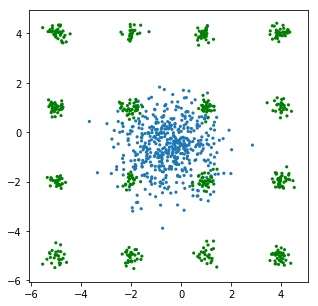

  4%|▍         | 989/25000 [00:06<02:39, 150.84it/s]

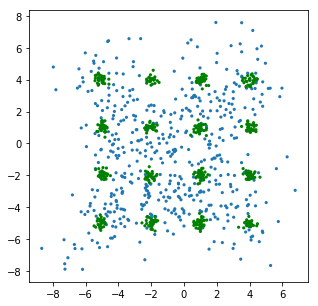

  8%|▊         | 1997/25000 [00:12<02:29, 153.74it/s]

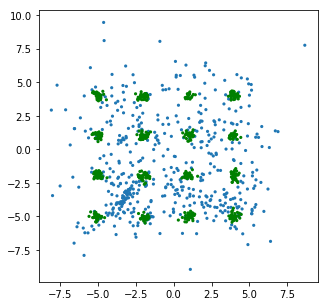

 12%|█▏        | 2989/25000 [00:19<02:23, 153.75it/s]

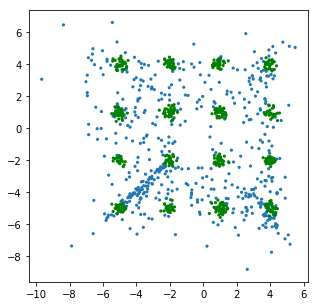

 16%|█▌        | 3988/25000 [00:25<02:16, 154.22it/s]

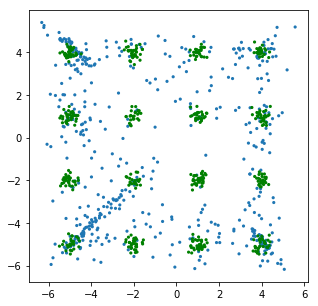

 20%|█▉        | 4987/25000 [00:32<02:09, 154.07it/s]

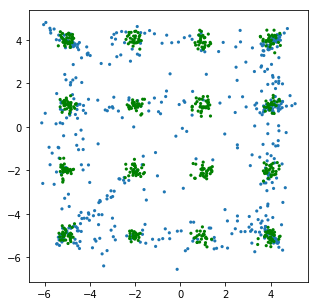

 24%|██▍       | 5984/25000 [00:38<02:03, 154.13it/s]

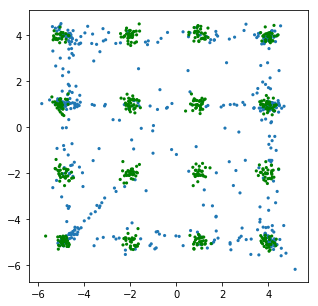

 28%|██▊       | 6985/25000 [00:45<01:56, 154.56it/s]

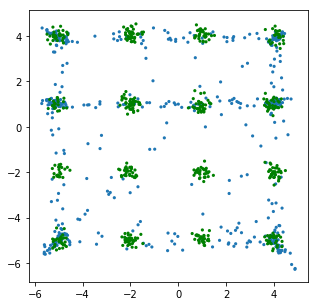

 32%|███▏      | 8000/25000 [00:51<01:50, 154.25it/s]

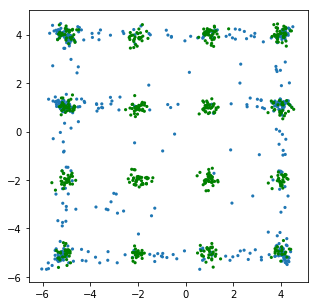

 36%|███▌      | 8995/25000 [00:58<01:43, 154.26it/s]

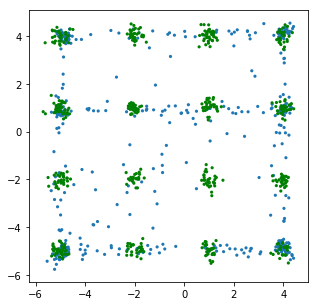

 40%|███▉      | 9994/25000 [01:04<01:37, 154.41it/s]

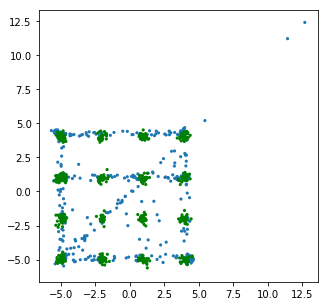

 44%|████▍     | 10991/25000 [01:11<01:30, 154.56it/s]

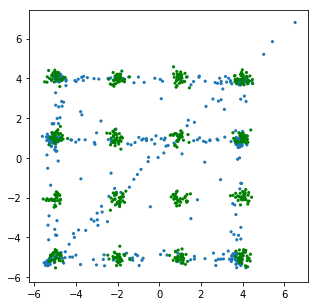

 48%|████▊     | 11987/25000 [01:17<01:24, 154.72it/s]

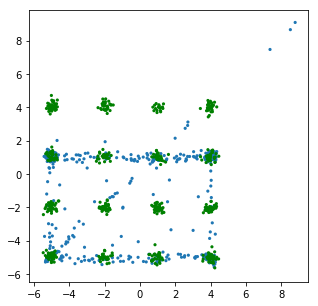

 52%|█████▏    | 12986/25000 [01:23<01:17, 154.96it/s]

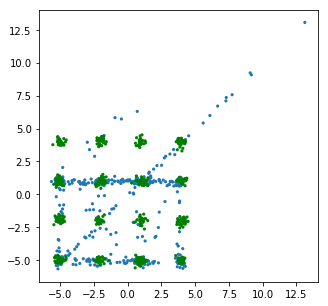

 56%|█████▌    | 13988/25000 [01:30<01:11, 154.53it/s]

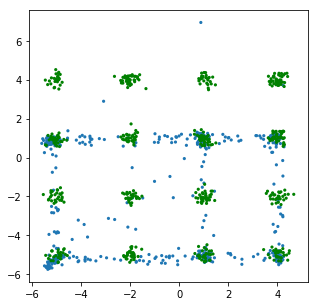

 60%|██████    | 15000/25000 [01:38<01:05, 152.99it/s]

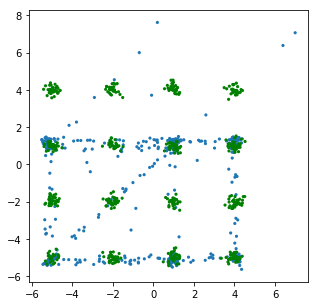

 64%|██████▍   | 15998/25000 [01:44<00:58, 153.04it/s]

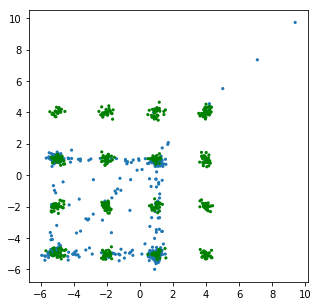

 68%|██████▊   | 16999/25000 [01:51<00:52, 153.02it/s]

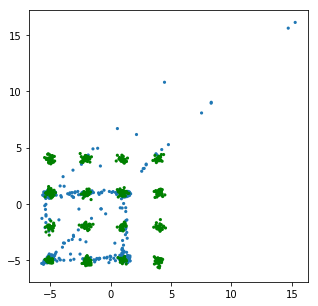

 72%|███████▏  | 17995/25000 [01:58<00:46, 152.07it/s]

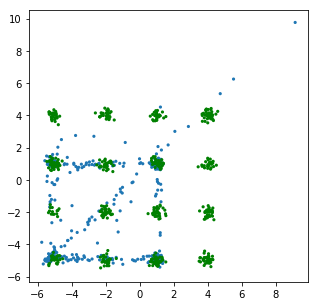

 76%|███████▌  | 18986/25000 [02:06<00:39, 150.48it/s]

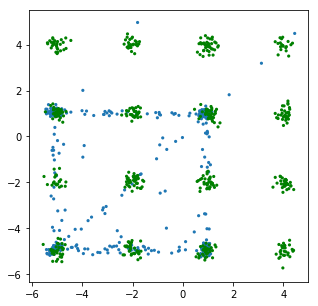

 80%|███████▉  | 19996/25000 [02:13<00:33, 149.86it/s]

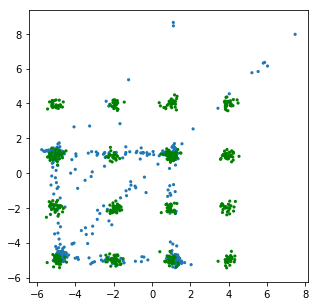

 84%|████████▍ | 20991/25000 [02:21<00:27, 147.87it/s]

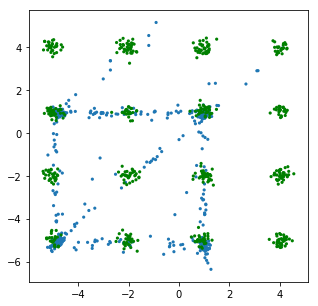

 88%|████████▊ | 21987/25000 [02:28<00:20, 148.11it/s]

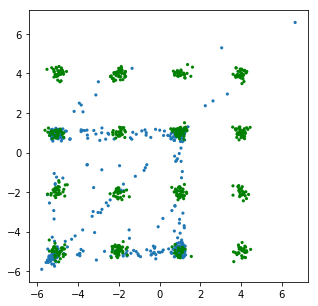

 92%|█████████▏| 22987/25000 [02:34<00:13, 148.40it/s]

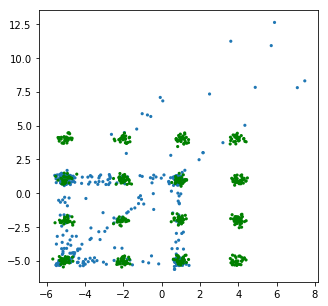

 96%|█████████▌| 23997/25000 [02:41<00:06, 148.37it/s]

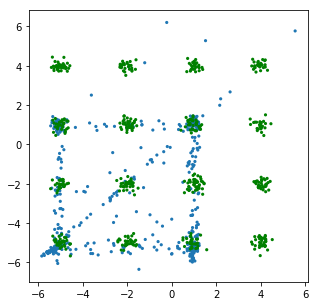

100%|██████████| 25000/25000 [02:48<00:00, 148.44it/s]


In [8]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
for i in tqdm(range(params['max_iter'])):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if i % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         axis('off')
        show()